In [5]:
import numpy as np
import pandas as pd
import io
from time import strptime, strftime
import datetime
# from google.colab import files
import re
import matplotlib.pyplot as plt
import scipy.stats 
import seaborn as sns
import plotly.graph_objects as go
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)


In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 25]

In [7]:
df_pt_to_res = pd.read_excel(r'C:/Users/mbarb/OneDrive/JPS/Informatics/Informatics_Project/night_tab_bolus/pt_to_res.xlsx')
df_res_to_shift = pd.read_excel(r'C:/Users/mbarb/OneDrive/JPS/Informatics/Informatics_Project/night_tab_bolus/res_to_shift.xlsx')

# Night Tab Change

## Night Tabs changed May 10 to include more rooms on Red side

### Night tab layout went from this:

![Original Night Tab](ED_Map_night_052020.png)

### To this:

![New Night Tab](JPSED_AreaMap_Night_052020.JPG)

#### R residents start to feel slammed overnight


#### And blame goes to the tab change


#### But is it really a problem?

Maybe just a few bad shifts in a row?


Natural variance in pt flow?

So to answer this question, we pull data from all patient arrivals 50 days before May 10th and 50 days after. 


And it looks like this:

![Pts seen by resident](pt_to_res_excel.png)

But to know __where__ each patient was roomed, we have to use the schedule data


That looks like this:

![Pts seen by resident](res_to_shift_excel.png)

### Data Cleaning

In [8]:
# Small data cleaning to match resident note author name with resident schedule names

# look for resident name entered and last,first without space and add a space
df_pt_to_res['Res'] = df_pt_to_res['Res'].apply(lambda x: re.sub(r'(?<=[,])(?=[\S])', r' ', x))
#df_pt_to_res['Res'] = df_pt_to_res['Res'].apply(lambda x: re.sub(r'(?<=[,])(?=[\S])', r' ', x))

# remove ", MD" and ", DO" from res name
#df_pt_to_res['Res'] =df_pt_to_res['Res'].apply(lambda x: x. split(" ")[0] + ' ' + x. split(" ")[1])
df_pt_to_res['Res'] = df_pt_to_res['Res'].apply(lambda x: x.replace(', MD', ''))
df_pt_to_res['Res'] = df_pt_to_res['Res'].apply(lambda x: x.replace(', DO', ''))

# remove ", MD" and ", DO" from doc name and use only last name, first name
df_pt_to_res['Doc'] =df_pt_to_res['Doc'].apply(lambda x: x. split(" ")[0] + ' ' + x. split(" ")[1])
#df_pt_to_res['Doc'] = df_pt_to_res['Doc'].apply(lambda x: x.replace(', MD', ''))
#df_pt_to_res['Doc'] = df_pt_to_res['Doc'].apply(lambda x: x.replace(', DO', ''))

# res name in schedule is different than res name when signing notes
df_pt_to_res['Res'] = df_pt_to_res['Res'].apply(lambda x: x.replace('Zeichner, Sidney', 'Zeichner, Ben'))

# Assigned Doc has mixed All caps and normal caps, make all lower everywhere for matching
df_pt_to_res['Doc'] = df_pt_to_res['Doc'].str.lower()
df_pt_to_res['Res'] = df_pt_to_res['Res'].str.lower()
df_res_to_shift['provider_name'] = df_res_to_shift['provider_name'].str.lower()

# Attending red shifts are listed as T1, T2 etc for trauma. Change the T to R changes PTO to PRO.
# too lazy to figure out regex for one line of code
df_res_to_shift['shift_name'] = df_res_to_shift['shift_name'].apply(lambda x: x.replace('T', 'R'))
df_res_to_shift['shift_name'] = df_res_to_shift['shift_name'].apply(lambda x: x.replace('PRO', 'PTO'))

# where IEC button not pressed, value is NaT (not a timestamp)
# reassign those missing values to the ed_arrival_dttm as best approximation

df_pt_to_res['iec_dttm'] = df_pt_to_res['iec_dttm'].fillna(df_pt_to_res['ed_room_dttm'][pd.isnull(df_pt_to_res['iec_dttm'])])

#s = pd.Series(df_pt_to_res['iec_dttm'].values.astype(float))
#s[s<0] = np.NaN

#df_pt_to_res['iec_dttm'] = pd.to_datetime(s.interpolate())

df_pt_to_res['iec_room_hour'] = df_pt_to_res['iec_dttm'].dt.hour
df_pt_to_res['iec_room_day'] = df_pt_to_res['iec_dttm'].dt.dayofyear

Match resident's shift to patient data

In [9]:
# take each note author resident name, the time the patient was seen, and match
# it to the schedule by resident name and shift time.
# Build list of the shift type

res_shift = []
note_author = []
res_on_shift = []

#residents pick up pts 15 minutes before official
#but residents STOP picking up ~ 30 minutes before
# and oncoming resident will backdate IEC time

pre_shift_window = datetime.timedelta(minutes=60)

for enc_idx, encounter in df_pt_to_res.iterrows():
    resident_oi = df_pt_to_res['Res'][enc_idx]
    #time_oi = df_pt_to_res['ed_arrival_dttm'][enc_idx]
    time_oi = df_pt_to_res['iec_dttm'][enc_idx]
    shift_obj = df_res_to_shift[((df_res_to_shift['start_dttm'] - pre_shift_window) < time_oi) &
                    (df_res_to_shift['end_dttm'] > time_oi) &
                    (df_res_to_shift['provider_name'] == resident_oi)].reset_index(drop=True)
    try:
        shift_type = shift_obj.loc[0,'shift_name']
        res_name = shift_obj.loc[0,'provider_name']
    except:
        prov_oi = df_pt_to_res['Doc'][enc_idx]
        #time_oi = df_pt_to_res['ed_arrival_dttm'][enc_idx]
        #time_oi = unmatched_df['iec_dttm'][enc_idx]
        shift_obj = df_res_to_shift[((df_res_to_shift['start_dttm'] - pre_shift_window) < time_oi) &
                    (df_res_to_shift['end_dttm'] > time_oi) &
                    (df_res_to_shift['provider_name'] == prov_oi)].reset_index(drop=True)
        try:
            shift_type = 'prov_' + shift_obj.loc[0,'shift_name']
            prov_name = shift_obj.loc[0,'provider_name']
        except:
            shift_type = str('no matched shift')
            prov_name = 'not matched'
    
    #prov_shift.append(shift_type)
    
    res_shift.append(shift_type)
    note_author.append(resident_oi)
    res_on_shift.append(res_name)


df_pt_to_res['res_shift_name'] = res_shift

################################################


In [10]:
df_pt_to_res.head(10)

,ed_arrival_dttm,acuity,chart_type,Doc,Res,APP,arrival_to_dispo_mins,arrival_to_room_mins,room_to_dispo_mins,dispo_to_depart_mins,doc_to_dispo_mins,door_to_doc_mins,room_to_doc_mins,ed_los_mins,ed_room_dttm,iec_dttm,room_iec_diff,ed_room_month,ed_room_day,ed_room_hour,number_of_res_working,total_number_of_hours,rn,iec_room_hour,iec_room_day,res_shift_name
0,2021-03-20 00:07:00,3.0,Res,"lopez, rebecka","khong, amy",NaN,215.0,24,212.0,150.0,216.0,24.0,0.0,366.0,2021-03-20 00:31:00,2021-03-20 00:31:00,0.0,3,79,0,7,66,1,0,79,RES B3u
1,2021-03-20 00:15:00,2.0,Res,"meyering, stefan","zeichner, ben",NaN,243.0,27,238.0,55.0,245.0,30.0,3.0,299.0,2021-03-20 00:42:00,2021-03-19 19:45:00,-297.0,3,79,0,7,66,1,19,78,RES A2i
2,2021-03-20 00:23:00,3.0,Res,"lopez, rebecka","barbaro, michael",NaN,184.0,2,182.0,40.0,185.0,4.0,1.0,225.0,2021-03-20 00:25:00,2021-03-20 00:27:00,2.0,3,79,0,7,66,1,0,79,RES B3i
3,2021-03-20 00:26:00,2.0,Res,"meyering, stefan","vo, vietvuong",NaN,130.0,4,126.0,41.0,131.0,4.0,1.0,172.0,2021-03-20 00:30:00,2021-03-20 00:30:00,0.0,3,79,0,7,66,1,0,79,RES A2u
4,2021-03-20 00:28:00,2.0,Res,"holmes, chad","starwalt, john",NaN,216.0,6,210.0,23.0,216.0,7.0,2.0,239.0,2021-03-20 00:34:00,2021-03-19 20:36:00,-238.0,3,79,0,7,66,1,20,78,RES R2u
5,2021-03-20 00:33:00,3.0,Res,"roberts, daniel","johansson, caj",NaN,92.0,4,89.0,26.0,92.0,7.0,3.0,118.0,2021-03-20 00:37:00,2021-03-20 00:39:00,2.0,3,79,0,7,66,1,0,79,RES R3i
6,2021-03-20 00:36:00,3.0,Res,"meyering, stefan","vo, vietvuong",NaN,104.0,25,100.0,40.0,104.0,26.0,1.0,143.0,2021-03-20 01:01:00,2021-03-20 01:02:00,1.0,3,79,1,7,66,1,1,79,RES A2u
7,2021-03-20 00:37:00,3.0,Res,"roberts, daniel","posey, rachel",NaN,20.0,4,16.0,56.0,22.0,9.0,5.0,76.0,2021-03-20 00:41:00,2021-03-20 00:46:00,5.0,3,79,0,7,66,1,0,79,RES R3u
8,2021-03-20 00:58:00,2.0,Res,"roberts, daniel","posey, rachel",NaN,68.0,8,121.0,0.0,175.0,14.0,6.0,372.0,2021-03-20 01:06:00,2021-03-20 01:12:00,6.0,3,79,1,7,66,1,1,79,RES R3u
9,2021-03-20 01:10:00,3.0,Res,"roberts, daniel","johansson, caj",NaN,73.0,7,66.0,16.0,74.0,8.0,1.0,89.0,2021-03-20 01:17:00,2021-03-20 01:18:00,1.0,3,79,1,7,66,1,1,79,RES R3i


Look at the data

In [11]:
df_pt_to_res[['ed_arrival_dttm', 'Doc', 'Res', 'res_shift_name', 
              'iec_dttm', 'iec_room_hour', 'iec_room_day']].head(10)

,ed_arrival_dttm,Doc,Res,res_shift_name,iec_dttm,iec_room_hour,iec_room_day
0,2021-03-20 00:07:00,"lopez, rebecka","khong, amy",RES B3u,2021-03-20 00:31:00,0,79
1,2021-03-20 00:15:00,"meyering, stefan","zeichner, ben",RES A2i,2021-03-19 19:45:00,19,78
2,2021-03-20 00:23:00,"lopez, rebecka","barbaro, michael",RES B3i,2021-03-20 00:27:00,0,79
3,2021-03-20 00:26:00,"meyering, stefan","vo, vietvuong",RES A2u,2021-03-20 00:30:00,0,79
4,2021-03-20 00:28:00,"holmes, chad","starwalt, john",RES R2u,2021-03-19 20:36:00,20,78
5,2021-03-20 00:33:00,"roberts, daniel","johansson, caj",RES R3i,2021-03-20 00:39:00,0,79
6,2021-03-20 00:36:00,"meyering, stefan","vo, vietvuong",RES A2u,2021-03-20 01:02:00,1,79
7,2021-03-20 00:37:00,"roberts, daniel","posey, rachel",RES R3u,2021-03-20 00:46:00,0,79
8,2021-03-20 00:58:00,"roberts, daniel","posey, rachel",RES R3u,2021-03-20 01:12:00,1,79
9,2021-03-20 01:10:00,"roberts, daniel","johansson, caj",RES R3i,2021-03-20 01:18:00,1,79


Extra Processing
 - Remove counts of 0 for Thursday mornings
 
 
 - Divide by number of residents per shift type

In [12]:
first_day = df_pt_to_res['iec_room_day'].min() + 1 #day 78 has 1 pt due to iec time diff
last_day = df_pt_to_res['iec_room_day'].max() + 1
wednesdays = np.arange(76,182, 7) 
pts_per_hour_array = np.empty((24, 6,(last_day - first_day))) * np.nan
day_key = np.zeros((last_day - first_day))
day_idx = 0
#or make this 3 dimensional
for day in range(first_day,last_day):
    #print("Day = " + str(day))
    day_key[day_idx] = day
    pts_per_hour_array[:,0,day_idx] = day
    for hour in range(24):
        pts_per_hour_array[hour,1,day_idx] = hour
        #print("Hour = " + str(hour))
        # pts seen by B residents in a given hour on a given day
        if (day in wednesdays) and hour >= 22: #if it's after 10 pm on a wednesday put nan instead of 0
            pts_per_hour_array[hour,2:,day_idx] = np.nan
        elif (day in wednesdays + 1) and hour < 13: #if it's before 1 pm on a thursday put nan instead of 0
            pts_per_hour_array[hour,2:,day_idx] = np.nan
        else:
            # pts seen by B residents in a given hour on a given day
            pts_per_hour_array[hour, 2, day_idx] = df_pt_to_res[(df_pt_to_res['iec_room_day']==day) & 
                        (df_pt_to_res['iec_room_hour'] == hour) &
                        (df_pt_to_res['res_shift_name'].str.contains('B', regex=False))].shape[0]
            
            # pts per resident in a given hour on a given day. 3 B residents from 2200 - 0500ish
            if (hour >= 22) or (hour <= 5):
                pts_per_hour_array[hour, 3, day_idx] = pts_per_hour_array[hour, 2, day_idx] / 3
            else:
                pts_per_hour_array[hour, 3, day_idx] = pts_per_hour_array[hour, 2, day_idx] / 2

            # pts seen by R residents in a given hour on a given day
            pts_per_hour_array[hour, 4, day_idx] = df_pt_to_res[(df_pt_to_res['iec_room_day']==day) & 
                        (df_pt_to_res['iec_room_hour'] == hour) &
                        (df_pt_to_res['res_shift_name'].str.contains(' R', regex=False))].shape[0]

            # pts per resident in a given hour on a given day. 2 R residents at all times
            pts_per_hour_array[hour, 5, day_idx]= pts_per_hour_array[hour, 4, day_idx] / 2

    day_idx += 1

        # print("B: " + str(df_pt_to_res[(df_pt_to_res['iec_room_day']==day) & 
        #             (df_pt_to_res['iec_room_hour'] == hour) &
        #             (df_pt_to_res['res_shift_name'].str.contains('B', regex=False))].shape[0]))
        # print("R: " + str(df_pt_to_res[(df_pt_to_res['iec_room_day']==day) & 
        #             (df_pt_to_res['iec_room_hour'] == hour) &
        #             (df_pt_to_res['res_shift_name'].str.contains('R', regex=False))].shape[0]))


# B is column 2 (3rd column), B/res is column 3 (4th), and R is column 4 (5th), R/res is column 5 (6th)

In [13]:
day_of_year = 129 # day of tab change
table_index = np.where(day_key == day_of_year)[0][0]

pre_chng_means = np.nanmean(pts_per_hour_array[:,:,:table_index], axis=2)
pre_chng_stdvs = np.nanstd(pts_per_hour_array[:,:,:table_index], axis=2)
post_chng_means = np.nanmean(pts_per_hour_array[:,:,table_index+1:], axis=2)
post_chng_stdvs = np.nanstd(pts_per_hour_array[:,:,table_index+1:], axis=2)

In [14]:
# b_color = (226/256, 214/256, 236/256, 1) # B Color (0.11, 0.21, 0.42, 1)
b_color = (209/256, 152/256,254/256, 1)
r_color = (227/256, 143/256, 143/256, 1) # R color (0.69, 0.02, 0.05, 1)
b_color_str = 'rgb(209, 152, 254)'
r_color_str = 'rgb(227, 143, 143)'

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 16

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### And finally, visualize it

Split the patients seen before the tab change and after the tab change

Split based on where they were seen

and average the numbers

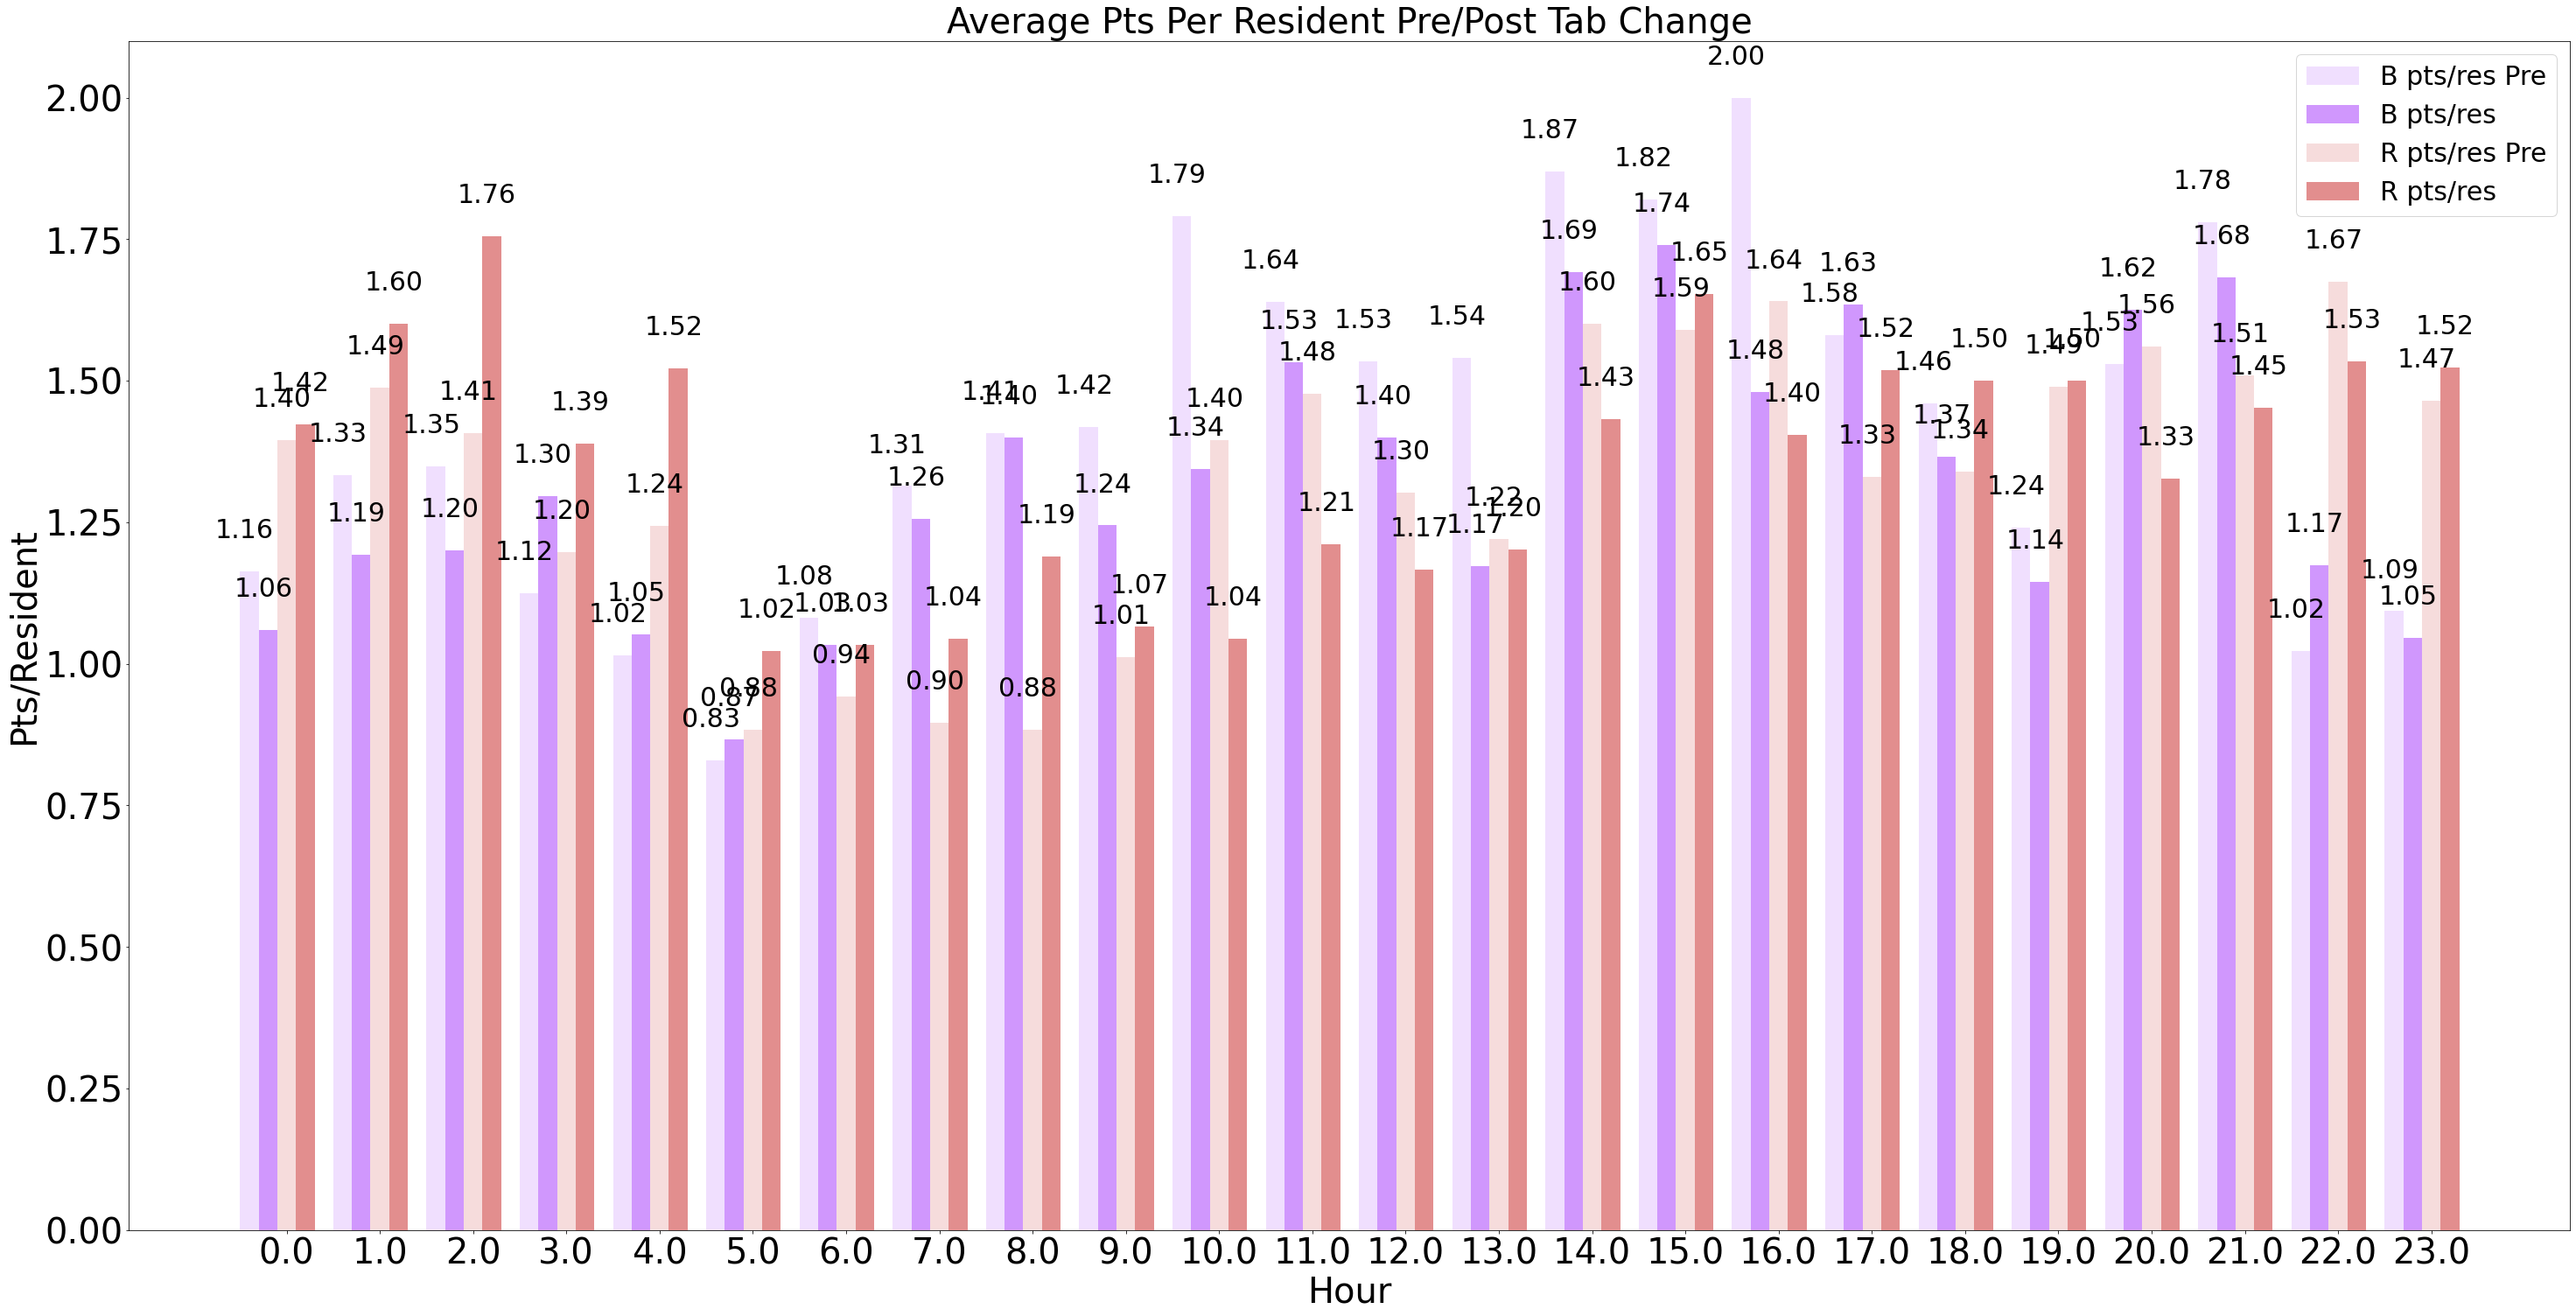

In [15]:
#plt.plot(pre_chng_means[:,1], pre_chng_means[:,2])
#plt.fill_between(pre_chng_means[:,1], pre_chng_means[:,2]-pre_chng_stdvs[:,2], pre_chng_means[:,2] + pre_chng_stdvs[:,2], alpha = 0.05)

labels = pre_chng_means[:,1]


x = pre_chng_means[:,1]  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(labels, pre_chng_means[:,3], width, label = "B pts/res Pre", color = b_color, alpha=0.3)
rects2 = ax.bar(labels + width, post_chng_means[:,3], width, label = "B pts/res", color = b_color)
rects3 = ax.bar(labels + 2*width, pre_chng_means[:,5], width, label = "R pts/res Pre", color = r_color, alpha=0.3)
rects4 = ax.bar(labels + 3*width, post_chng_means[:,5], width, label = "R pts/res", color = r_color)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pts/Resident', fontsize=40)
ax.set_title('Average Pts Per Resident Pre/Post Tab Change', fontsize=40)
ax.set_xlabel('Hour', fontsize=40)
ax.set_xticks(x + 2*width)
ax.set_xticklabels(labels, fontsize=40)
ax.legend(fontsize=30)
plt.yticks(fontsize=40)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/4, height + 0.05,
                '%1.2f' % float(height),
                ha='center', va='bottom', fontsize=30)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)


# fig.tight_layout()

plt.show()

In [16]:
# pre_change_df = df_pt_to_res[df_pt_to_res['iec_room_day'] < 130]
# post_change_df = df_pt_to_res[df_pt_to_res['iec_room_day'] > 130]
# pre day range from 79 - 129
# pre_change_df['iec_room_day'].max() - pre_change_df['iec_room_day'].min() = 50
# post_change_df['iec_room_day'].max() - post_change_df['iec_room_day'].min() = 50

Lets narrow that down

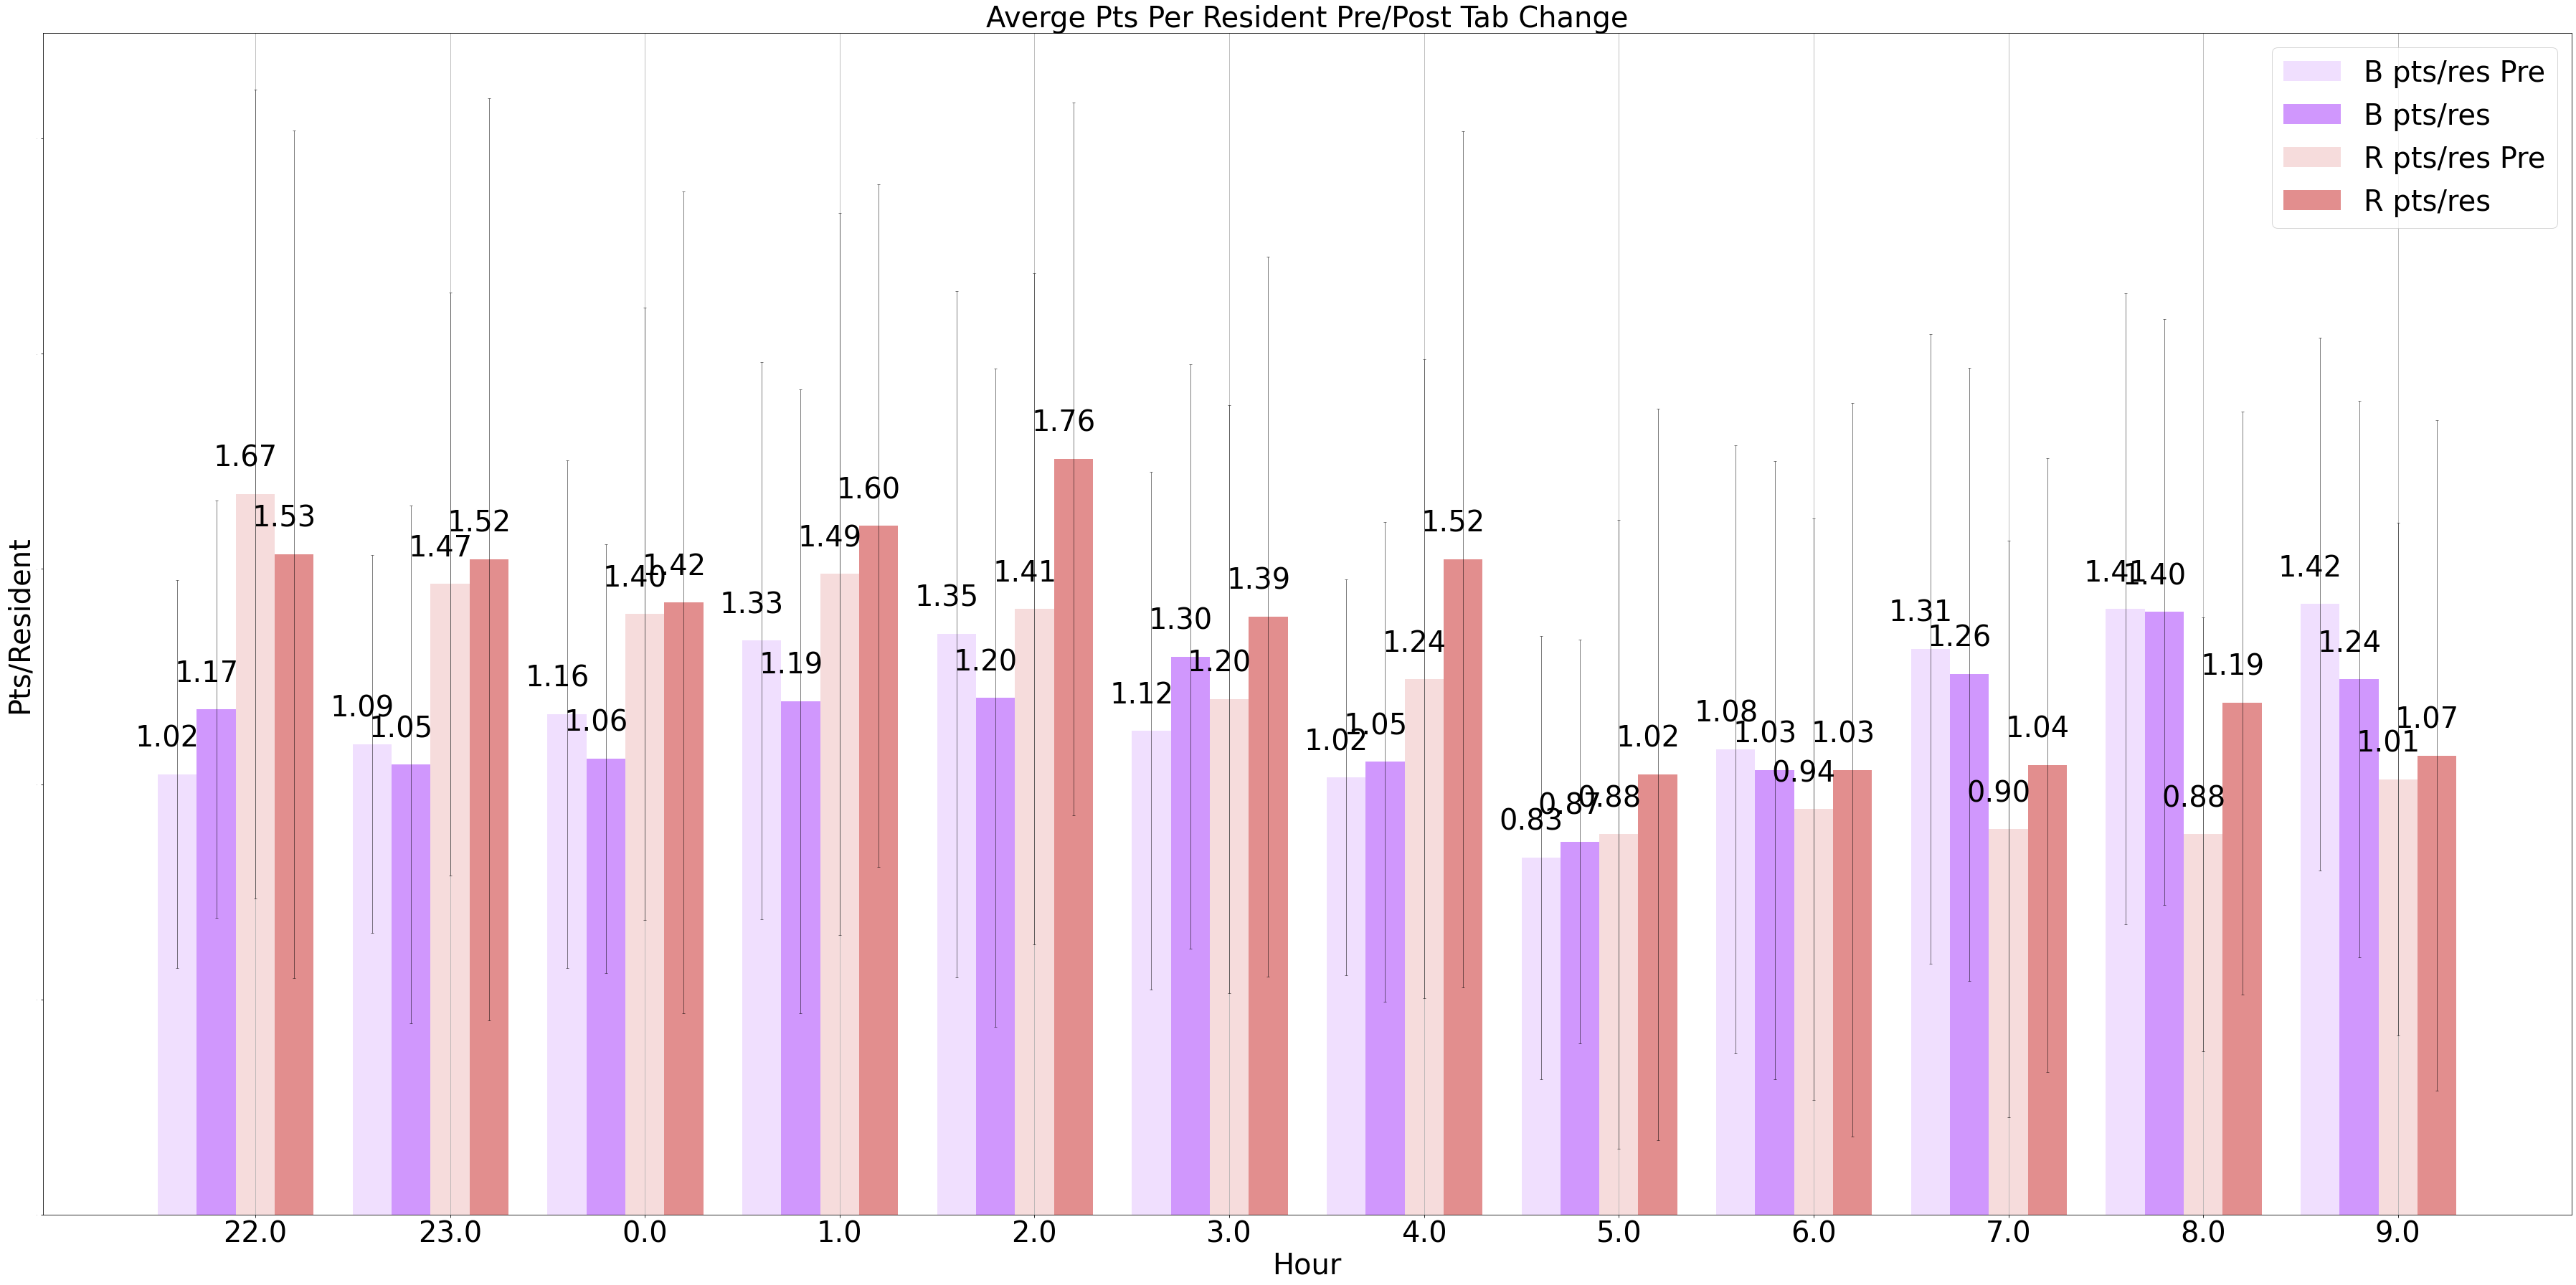

In [17]:

ns_start= 22
ns_end  = 10

# labels = pre_chng_means[:,1]
labels = np.concatenate((pre_chng_means[ns_start:,1], pre_chng_means[:ns_end,1]))

x = np.array(range(len(labels)))
# x = pre_chng_means[:,1]  # the label locations
width = 0.2  # the width of the bars
error_settings = {'capsize': 2, 'elinewidth': 1, 'alpha':0.5}


fig, ax = plt.subplots()
# pre_chng_means[[22, 23, 0,1,2,3,4,5],3])
rects1 = ax.bar(x, np.concatenate((pre_chng_means[ns_start:,3], pre_chng_means[:ns_end,3])),
                width, label = "B pts/res Pre", color = b_color, alpha=0.3,
                yerr = np.concatenate((pre_chng_stdvs[ns_start:,3], pre_chng_stdvs[:ns_end,3])), error_kw = error_settings)

rects2 = ax.bar(x + width, np.concatenate((post_chng_means[ns_start:,3], post_chng_means[:ns_end,3])), 
                width, label = "B pts/res", color = b_color,
                yerr = np.concatenate((post_chng_stdvs[ns_start:,3], post_chng_stdvs[:ns_end,3])), error_kw = error_settings)

rects3 = ax.bar(x + 2*width, np.concatenate((pre_chng_means[ns_start:,5], pre_chng_means[:ns_end,5])), 
                width, label = "R pts/res Pre", color = r_color, alpha=0.3,
                yerr = np.concatenate((pre_chng_stdvs[ns_start:,5], pre_chng_stdvs[:ns_end,5])), error_kw = error_settings)

rects4 = ax.bar(x + 3*width, np.concatenate((post_chng_means[ns_start:,5], post_chng_means[:ns_end,5])), 
                width, label = "R pts/res", color = r_color,
                yerr = np.concatenate((post_chng_stdvs[ns_start:,5], post_chng_stdvs[:ns_end,5])), error_kw = error_settings)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.xaxis.grid(True)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pts/Resident', fontsize=40)
ax.set_title('Averge Pts Per Resident Pre/Post Tab Change', fontsize=40)
ax.set_xlabel('Hour', fontsize=40)
ax.set_xticks(x + 2*width)
ax.set_xticklabels(labels, fontsize=40)
ax.legend(fontsize=40)
plt.yticks(fontsize=0)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/4, height + 0.05,
                '%1.2f' % float(height), fontsize=40,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

In [18]:
pts_per_hour_array_unroll = np.empty((24*103,6))
start = 0
end = 24
for i in range(103):
    pts_per_hour_array_unroll[start:end,:] = pts_per_hour_array[:,:,i]
    start += 24
    end += 24

In [19]:
# [day, hour, b pts in hour, b pts/res in hour, r pts in hour, b pts/res in hour]
pts_per_hour_df = pd.DataFrame(pts_per_hour_array_unroll, columns=['Day', 'Hour', 'b_pts_in_hour', 'b_pts/res_in_hour', 'r_pts_in_hour', 'r_pts/res_in_hour'])
pts_per_hour_df['total_pts'] = pts_per_hour_df['b_pts_in_hour'] + pts_per_hour_df['r_pts_in_hour']

pts_per_hour_df['total_pts_per_total_res'] = pts_per_hour_df['total_pts']/4
pts_per_hour_df.loc[pts_per_hour_df['Hour'] < 6, 'total_pts_per_total_res'] = pts_per_hour_df.loc[pts_per_hour_df['Hour'] < 6, 'total_pts']/5
pts_per_hour_df.loc[pts_per_hour_df['Hour'] >21, 'total_pts_per_total_res'] = pts_per_hour_df.loc[pts_per_hour_df['Hour'] > 21, 'total_pts']/5

# pts_per_hour_df


In [20]:
melted_df = pts_per_hour_df.melt(id_vars=['Day', 'Hour'], value_vars=['b_pts/res_in_hour', 'r_pts/res_in_hour'],
                     var_name='Location', value_name='pts/res_in_hour')

melted_df['Location'] = melted_df['Location'].apply(lambda x: x.replace('b_pts/res_in_hour', 'B'))
melted_df['Location'] = melted_df['Location'].apply(lambda x: x.replace('r_pts/res_in_hour', 'R'))

post_df_melt = melted_df[melted_df['Day'] > 130]
post_df = pts_per_hour_df[pts_per_hour_df['Day'] > 130]

### Is there another way to look at averages, that also shows the distribution?

![img](violin_plot.png)

#### Violin Plots of the previous bar charts

In [21]:
# sub_df = post_df[post_df['Hour'] < 6]
sub_df = post_df_melt
fig = go.Figure()


fig.add_trace(go.Violin(x=sub_df['Hour'][sub_df['Location'] == 'B'],
                        y=sub_df['pts/res_in_hour'][sub_df['Location'] == 'B'],
                        legendgroup='B', name='B',
                        box_visible=True,
                        # side = 'negative',
#                         pointpos=0,
                        line_color= b_color_str,
                        meanline_visible=True)
        )

fig.add_trace(go.Violin(x=sub_df['Hour'][sub_df['Location'] == 'R'],
                    y=sub_df['pts/res_in_hour'][sub_df['Location'] == 'R'],
                    legendgroup='R', scalegroup='R', name='R',
                    box_visible=True,
                    # side='positive',
                    pointpos=0,
                    line_color= r_color_str,
                    meanline_visible=True)
            )

# fig.add_trace(go.Violin(x=sub_df['Hour'][sub_df['Location'] == 'B'],
#                         y=sub_df['pts/res_in_hour'][sub_df['Location'] == 'B'],
#                         legendgroup='B', name='B',
#                         side = 'negative',
#                         pointpos=-0.3,
#                         line_color= b_color_str,
#                         meanline_visible=True)
#         )

# fig.add_trace(go.Violin(x=sub_df['Hour'][sub_df['Location'] == 'R'],
#                     y=sub_df['pts/res_in_hour'][sub_df['Location'] == 'R'],
#                     legendgroup='R', scalegroup='R', name='R',
#                     side='positive',
#                     pointpos=0.3,
#                     line_color= r_color_str,
#                     meanline_visible=True)
#             )

    

fig.update_traces(meanline_visible=True)
#                   ,points='all', # show all points
#                   jitter=0.5)  # add some jitter on points for better visibility
 #                 scalemode='count') #scale violin plot area with total count
# fig.update_layout(violingap=0, violinmode='overlay')
fig.update_layout(violinmode = 'group',
                  title = 'B + R After Tab Change',
                  yaxis_title = 'Pts/Res',
                  xaxis_title = 'Hour',
                  font=dict(size=18))
fig.show("svg")


In [25]:
fig.write_html("B_R_ptsperres_violin-t.html", include_plotlyjs=0)

![B_R_violin](B_R_ptsperres_violin.html)

In [24]:
from IPython.display import IFrame

IFrame(src='B_R_ptsperres_violin.html', width=700, height=600)


### So what do we do about it?

In [22]:
sub_df = pts_per_hour_df[(pts_per_hour_df['Hour'] < 10)]
# sub_df = pts_per_hour_df[(pts_per_hour_df['Hour'] > 1) & (pts_per_hour_df['Hour'] < 10)]
comb_color = 'rgb(220,183,221)'

fig = go.Figure()


fig.add_trace(go.Violin(x=sub_df['Hour'],
                        y=sub_df['total_pts_per_total_res'],
                        box_visible=True,
                        # side = 'negative',
                        pointpos=0,
                        line_color= comb_color,
                        meanline_visible=True)
        )
    

fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.5)  # add some jitter on points for better visibility
 #                 scalemode='count') #scale violin plot area with total count
# fig.update_layout(violingap=0, violinmode='overlay')
fig.update_layout(violinmode = 'group',
                  title = '0-9 am B + R Combined',
                  yaxis_title = 'Pts/Res',
                  xaxis_title = 'Hour',
                  font=dict(size=18))
fig.show("svg")